In [93]:
import json
import pandas as pd
from matplotlib import pyplot as plt

import scipy
import matplotlib.pyplot as plt 
import seaborn as sns


## Translate Hog JSON into Hog and Prediction tables

In [8]:
with open('data/groundhogs.json') as f:
    raw_hogs = json.load(f)

rel_keys = list(raw_hogs['groundhogs'][0].keys())[:-2]
hog_data = {k:[] for k in rel_keys}
prediction_data =  {'year': [], 'shadow': [], 'details': [], 'hog_id':[]}
for i in range(len(raw_hogs['groundhogs'])):
    for k in rel_keys:
        hog_data[k].append(raw_hogs['groundhogs'][i][k])
    for pred in raw_hogs['groundhogs'][i]['predictions']:
        for pk in prediction_data.keys():
            if pk != 'hog_id':
                prediction_data[pk].append(pred[pk])
            else:
                prediction_data[pk].append(hog_data['id'][-1])

hog_df = pd.DataFrame(hog_data)
hog_df['lat'] = hog_df['coordinates'].apply(lambda x: x.split(',')[0])
hog_df['lon'] = hog_df['coordinates'].apply(lambda x: x.split(',')[1])
hog_df['is_alliterative'] = (hog_df['name'].apply(lambda n : n.split(' ')[0][0].upper() == n.split(' ')[-1][0].upper())) * 1
hog_df['is_charles'] = (hog_df['name'].apply(lambda n :  any(word in n.upper() for word in ['charles','chuck','charlie','charley']))) * 1
hog_df['is_absolute_hog'] = (hog_df['type'] == 'Groundhog') * 1
hog_df['is_hog'] = (hog_df['type'].apply(lambda n : any(word.upper() in n.upper() for word in ['groundhog']))) * 1
hog_df['is_human'] = (hog_df['type'].apply(lambda n : 'PERSON' in n.upper())) * 1
hog_df['is_alive'] = (hog_df['type'].apply(lambda n : not(any(word.upper() in n.upper() for word in ['taxidermied','statue','plush','puppet'])))) * 1

In [ ]:
pred_df = pd.DataFrame(prediction_data).reset_index()
pred_df.rename({'index':'prediction_id'},axis=1,inplace=True)
pred_map = pd.merge(pred_df,hog_df[['id','city','region','country']],left_on='hog_id',right_on='id')[['shadow','prediction_id','year','details','hog_id','city','region','country']]

## Get temperature measurements from NCEI

In [9]:
state_codes = {
'001': 'Alabama',
'030': 'New York',
'002': 'Arizona',
'031': 'North Carolina',
'003': 'Arkansas',
'032': 'North Dakota',
'004': 'California',
'033': 'Ohio',
'005': 'Colorado',
'034': 'Oklahoma',
'006': 'Connecticut',
'035': 'Oregon',
'007': 'Delaware',
'036': 'Pennsylvania',
'008': 'Florida',
'037': 'Rhode Island',
'009': 'Georgia',
'038': 'South Carolina',
'010': 'Idaho',
'039': 'South Dakota',
'011': 'Illinois',
'040': 'Tennessee',
'012': 'Indiana',
'041': 'Texas',
'013': 'Iowa',
'042': 'Utah',
'014': 'Kansas',
'043': 'Vermont',
'015': 'Kentucky',
'044': 'Virginia',
'016': 'Louisiana',
'045': 'Washington',
'017': 'Maine',
'046': 'West Virginia',
'018': 'Maryland',
'047': 'Wisconsin',
'019': 'Massachusetts',
'048': 'Wyoming',
'020': 'Michigan',
'050': 'Alaska',
'021': 'Minnesota',
'022': 'Mississippi',
'023': 'Missouri',
'024': 'Montana',
'025': 'Nebraska',
'026': 'Nevada',
'027': 'New Hampshire',
'028': 'New Jersey',
'029': 'New Mexico',
}
dtype = {
    'id': str,
    'jan': float,
    'feb': float,
    'mar': float,
    'apr': float,
    'may': float,
    'jun': float,
    'jul': float,
    'aug': float,
    'sep': float,
    'oct': float,
    'nov': float,
    'dec': float,
}

temps = pd.read_csv('data/state_tmp_month_avg.txt',sep='_',dtype=dtype)

def state_mapper(time_loc_code):
    try:
        return state_codes[(time_loc_code)[0:3]]
    except:
        return None

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

temps['state'] = temps.id.apply(lambda r : state_mapper(r))
temps = temps[temps['state'].notna()]
temps['year'] = temps.id.apply(lambda r: r[-4:]).astype(int)
temps = temps[temps['year'] != 2024]
temp_df = temps[['state','year','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]

# Get rolling averages for predictions

In [15]:
rolling_temps_df = temp_df[months].rolling(3).sum()
rolling_temps_df['before_prediction'] = (rolling_temps_df['nov'] + rolling_temps_df['dec'] + rolling_temps_df['jan'])/9
rolling_temps_df['after_prediction'] = (rolling_temps_df['feb'] + rolling_temps_df['mar'] + rolling_temps_df['apr'])/9
temp_df['before_prediction_avg'] = rolling_temps_df['before_prediction']
temp_df['after_prediction_avg'] = rolling_temps_df['after_prediction']

double_roll = rolling_temps_df[['before_prediction','after_prediction']].rolling(3).mean()

temp_df['rolling_before_prediction_avg_3yr'] = double_roll['before_prediction']
temp_df['rolling_after_prediction_avg_3yr'] = double_roll['after_prediction']

## Determine accuracy and P-Values of hogs
Note: This excludes any Groundhog that is in the District of Columbia (not available from NCEI), Elliott (it's his first year, give him a break), or Canadian (Canadian).  
P-Value assumes that every hog has a 50:50 shot of being correct - this is a baseline and does not necessarily reflect reality. We'll explore a per-region P(Long Winter) later

In [16]:
pred_df = pd.DataFrame(prediction_data).reset_index()
pred_df.rename({'index':'prediction_id'},axis=1,inplace=True)
prediction_df = pd.merge(pred_df,hog_df[['id','city','region','country']],left_on='hog_id',right_on='id')[['shadow','prediction_id','year','details','hog_id','city','region','country']]
prediction_df = prediction_df.dropna()
accuracy_df = pd.merge(prediction_df,temp_df,left_on=['region','year'],right_on=['state','year'],how='inner')

def is_correct(row):
    return 1 * ((row.shadow == 1 and row.after_prediction_avg <= row.rolling_after_prediction_avg_3yr) or (row.shadow == 0 and row.after_prediction_avg > row.rolling_after_prediction_avg_3yr))

accuracy_df['correct'] = accuracy_df.apply(lambda r : is_correct(r),axis=1)
hog_df['accuracy_3yr'] = hog_df.id.map(accuracy_df[['hog_id','correct']].groupby('hog_id').mean()[['correct']].reset_index().set_index('hog_id')['correct'].to_dict())
hog_df['hits'] = hog_df.id.map(accuracy_df[['hog_id','correct']].groupby('hog_id').sum()[['correct']].reset_index().set_index('hog_id')['correct'].to_dict())
hog_df['predictions'] = hog_df.id.map(accuracy_df[['hog_id','correct']].groupby('hog_id').count()[['correct']].reset_index().set_index('hog_id')['correct'].to_dict())

measured_hogs_df = hog_df[~hog_df['hits'].isna()]
measured_hogs_df['p_value'] = measured_hogs_df.apply(lambda row: scipy.stats.binom_test(row['hits'], row['predictions'], 0.5, alternative='greater'), axis=1)

/var/folders/vv/vfkp_md141s7kfvvrkq_7hmw0000gn/T/ipykernel_8676/895983684.py:17: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  measured_hogs_df['p_value'] = measured_hogs_df.apply(lambda row: scipy.stats.binom_test(row['hits'], row['predictions'], 0.5, alternative='greater'), axis=1)
/var/folders/vv/vfkp_md141s7kfvvrkq_7hmw0000gn/T/ipykernel_8676/895983684.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measured_hogs_df['p_value'] = measured_hogs_df.apply(lambda row: scipy.stats.binom_test(row['hits'], row['predictions'], 0.5, alternative='greater'), axis=1)


# Plot hogs, assuming P(Long Winter) = 0.5

/var/folders/vv/vfkp_md141s7kfvvrkq_7hmw0000gn/T/ipykernel_8676/595452184.py:2: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  measured_hogs_df['p_value'] = measured_hogs_df.apply(lambda row: scipy.stats.binom_test(row['hits'], row['predictions'], p), axis=1)
/var/folders/vv/vfkp_md141s7kfvvrkq_7hmw0000gn/T/ipykernel_8676/595452184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measured_hogs_df['p_value'] = measured_hogs_df.apply(lambda row: scipy.stats.binom_test(row['hits'], row['predictions'], p), axis=1)


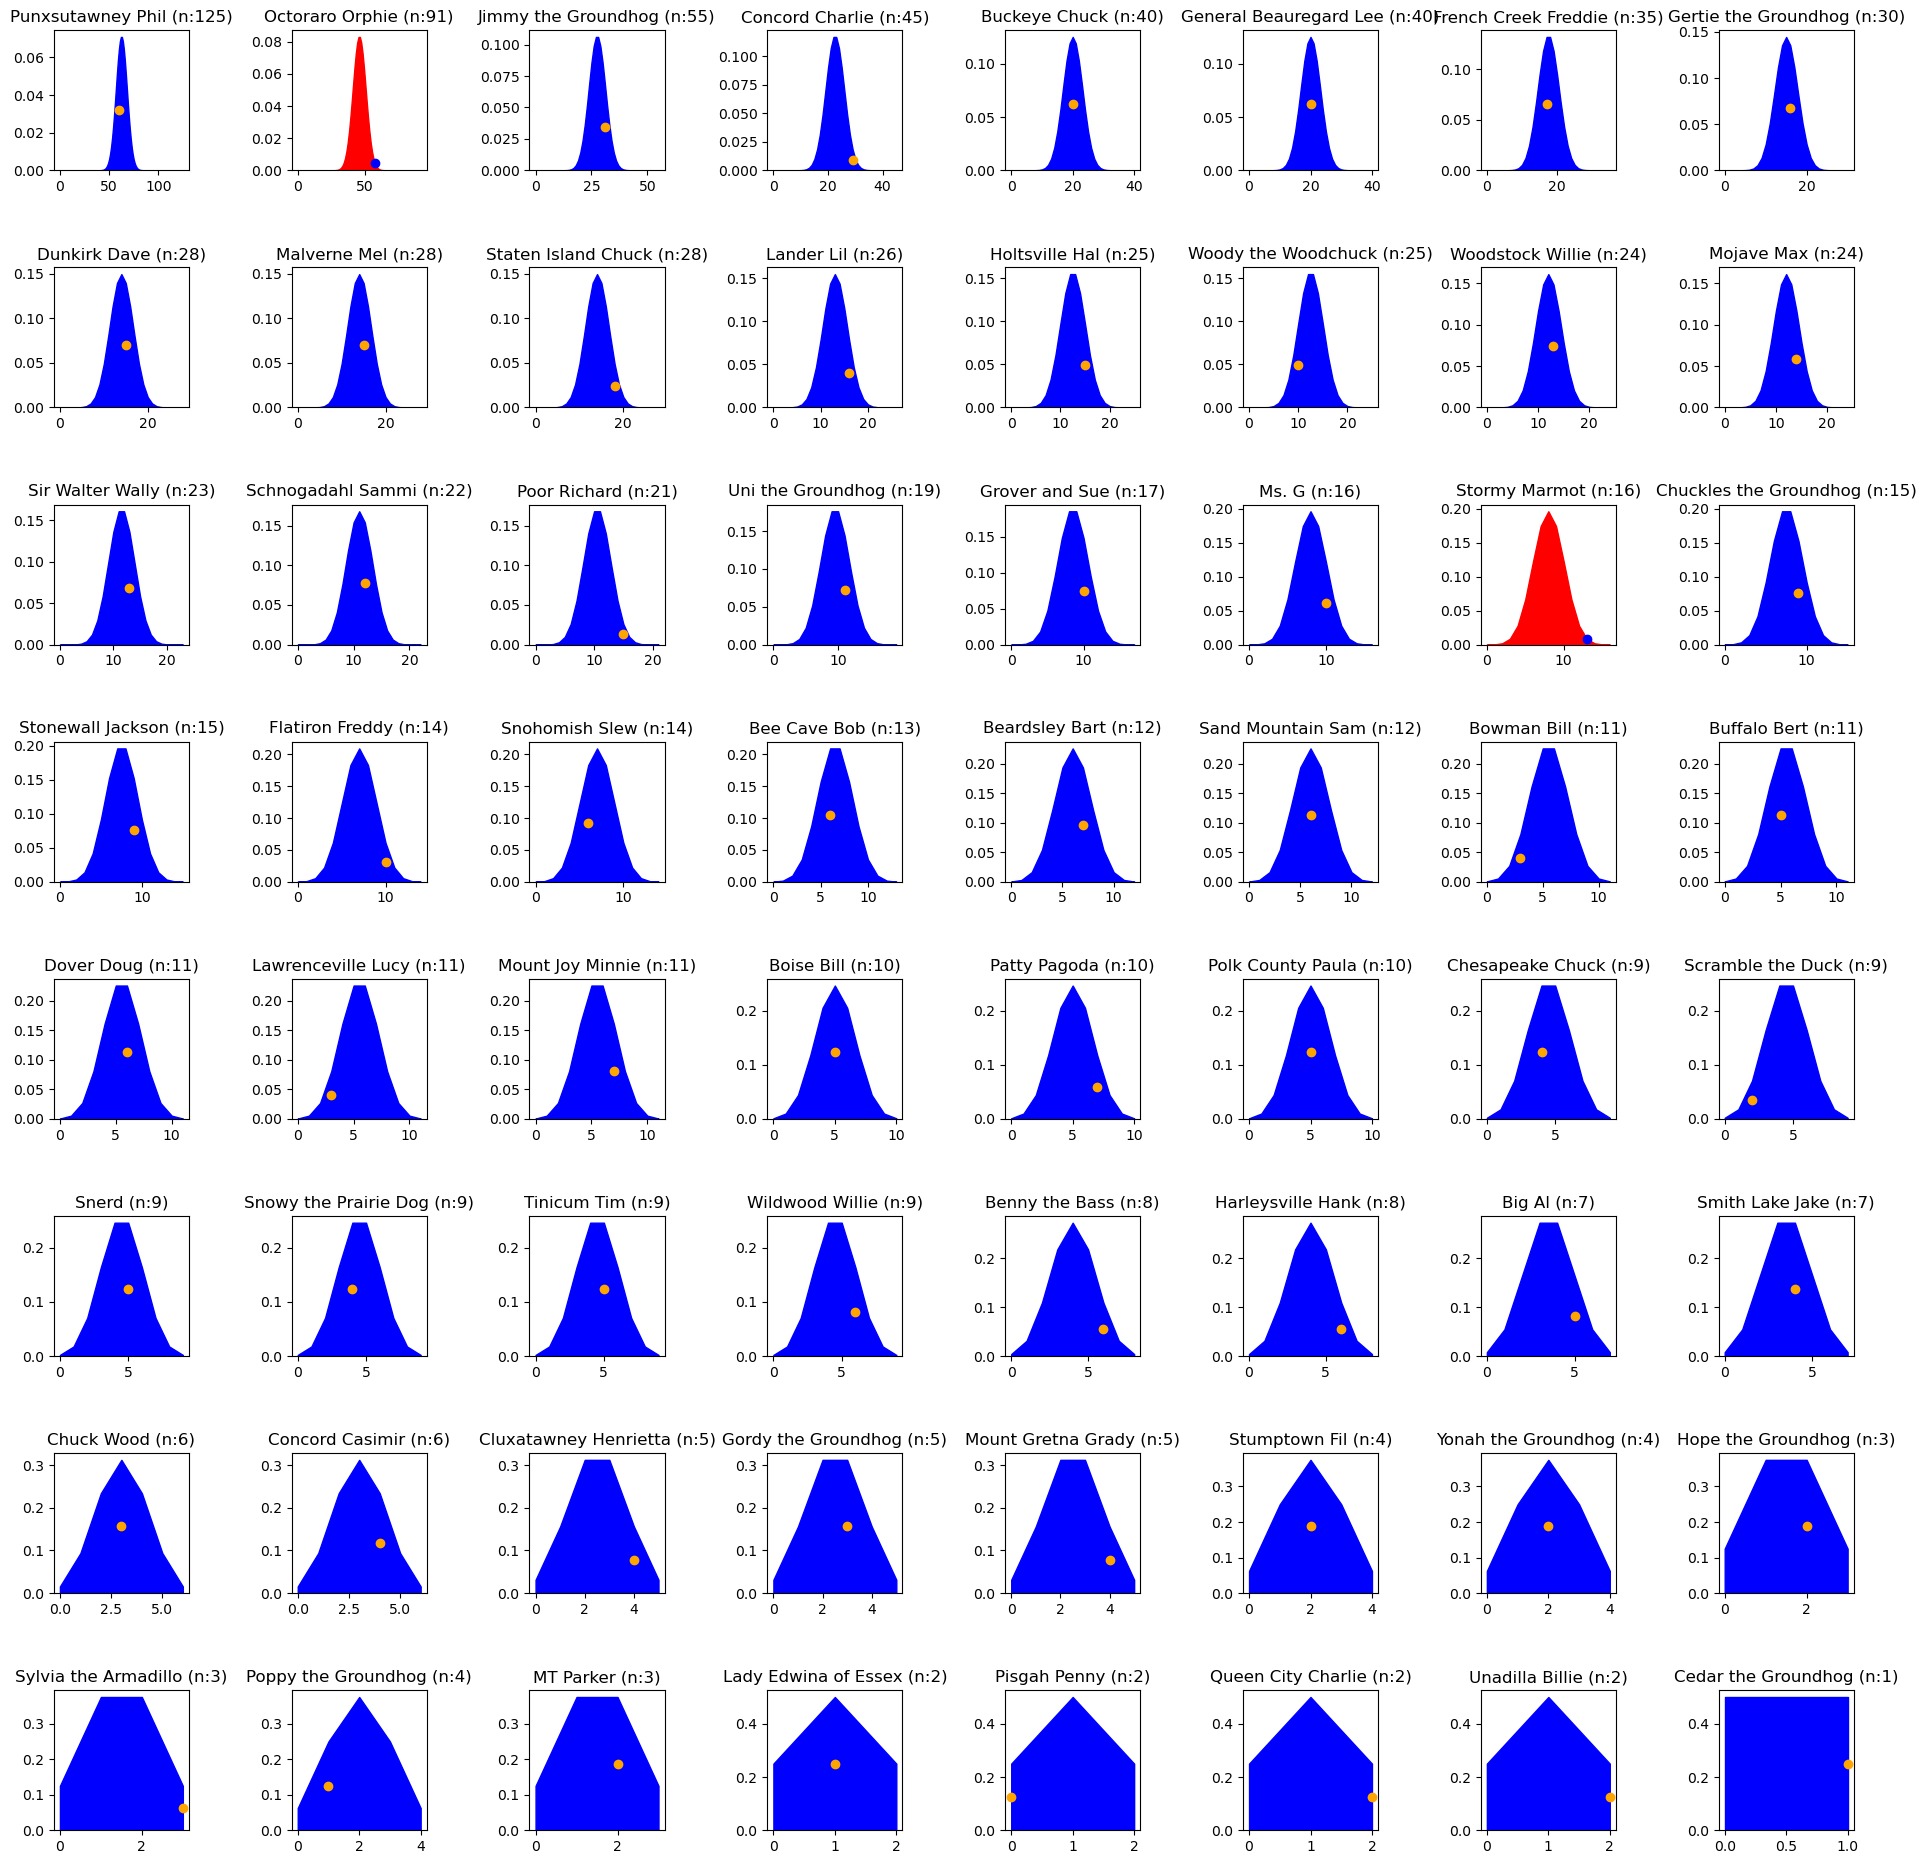

In [88]:
p = 0.5
measured_hogs_df['p_value'] = measured_hogs_df.apply(lambda row: scipy.stats.binom_test(row['hits'], row['predictions'], p), axis=1)

n_rows, n_cols = 8, 8
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
i = 0
for row in measured_hogs_df.itertuples():
    n = row.predictions
    
    # defining list of r values 
    r_values = list(range(int(n) + 1)) 
    # list of pmf values 
    dist = [scipy.stats.binom.pmf(r, n, p) for r in r_values ] 
    #dist = [d if d > 0.05 else 0 for d in dist]
    # plotting the graph  
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    if row.p_value > 0.05:
        ax.fill_between(r_values, dist,color='blue')
        ax.scatter(row.hits,scipy.stats.binom.pmf(row.hits, row.predictions, 0.5)/2,c='orange')
    else:
        ax.fill_between(r_values, dist,color='red') 
        ax.scatter(row.hits,scipy.stats.binom.pmf(row.hits, row.predictions, 0.5),c='blue')
    ax.set_title(f"{row.name} (n:{int(row.predictions)})")
    ax.set_ylim(0,ax.get_ylim()[1])
    i+=1


plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()

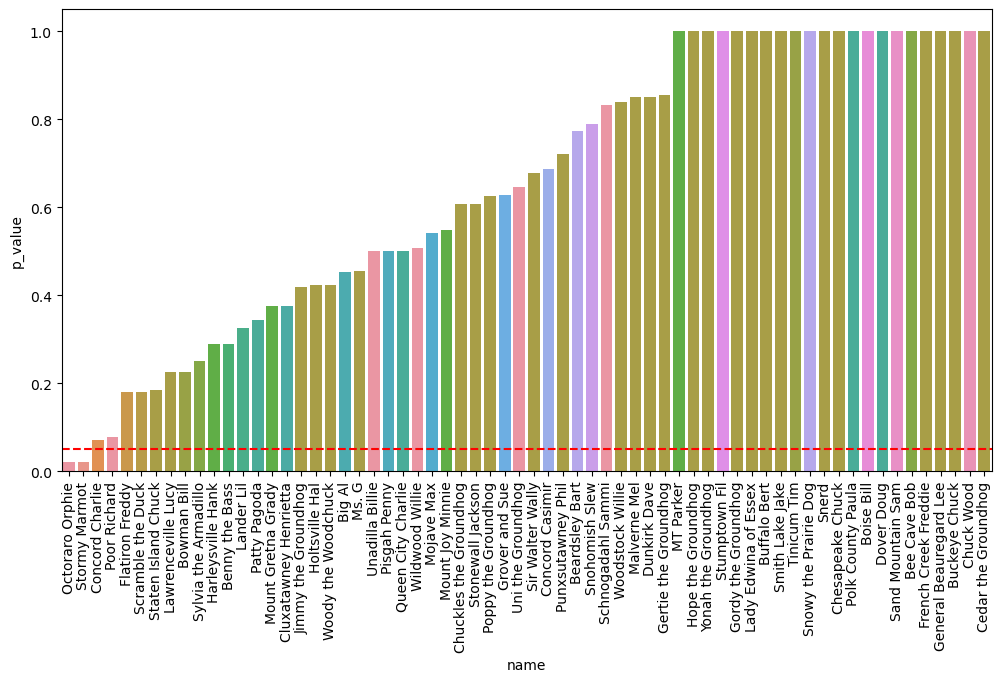

In [101]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data = measured_hogs_df.sort_values('p_value'), x='name', y='p_value', hue='type', dodge=False)
plt.axhline(y=0.05, color='r', alpha=1,linestyle='--', label='Significance Threshold (0.05)')
plt.xticks(rotation=90)
plt.legend([],[], frameon=False)
plt.show()

In [7]:
hog_df.to_csv('data/hogs.csv',sep='\t') # https://groundhog-day.com/
pred_map.to_csv('data/prediction_map.tsv',sep='\t') # https://groundhog-day.com/
temp_df.to_csv('data/simple_state_month_temp_averages.csv',index=False) # https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmpcst-v1.0.0-20240705 

In [91]:
measured_hogs_df.sort_values('p_value')['type']

1                 Taxidermied groundhog
26          Plush yellow-bellied marmot
4                    Presumed groundhog
21                Taxidermied groundhog
29    Taxidermied yellow-bellied marmot
                    ...                
7                             Groundhog
6                             Groundhog
5                             Groundhog
60                Animatronic groundhog
78                            Groundhog
Name: type, Length: 64, dtype: object